In [1]:
nCPU = 4
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, timeit, json
os.environ['OMP_NUM_THREADS'] = str(nCPU)
os.environ['MKL_NUM_THREADS'] = str(nCPU)
os.environ['NUMEXPR_NUM_THREADS'] = str(nCPU)
from tqdm.auto import tqdm, trange
from collections import OrderedDict, deque, defaultdict
from pathlib import Path

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, pandas as pd, scipy
from scipy.stats import zscore, ttest_ind, spearmanr, pearsonr
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP

torch.set_num_threads(nCPU)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

from model import SpiceMixPlus

In [2]:
import anndata as ad

In [3]:
context = dict(device='cuda:0', dtype=torch.float32)

In [4]:
def reload_all():
    import model, load_data, estimate_parameters, estimate_weights, util, initialization, sample_for_integral
    importlib.reload(util)
    importlib.reload(load_data)
    importlib.reload(sample_for_integral)
    importlib.reload(estimate_parameters)
    importlib.reload(estimate_weights)
    importlib.reload(initialization)
    importlib.reload(model)

reload_all()

In [5]:
# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i4')
# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i5')
# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i4')
# path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_30_15_0_0_i0')
# path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_30_15_0_0_i1')
# path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_30_15_0_0_i2')
# repli_list = ['0', '1']

path2dataset = Path("../tests/test_data/synthetic_500_100_20_15_0_0_i4/")
repli_list = ['0', '1']

coor = np.loadtxt(path2dataset / 'files' / 'coordinates_0.txt')

In [6]:
obj = SpiceMixPlus(
    K=10, lambda_Sigma_x_inv=1e-2,
    repli_list=repli_list,
    context=context,
#     context_Y=dict(dtype=torch.float32, device='cpu'),
    context_Y=context,
    random_state=2
)
dataset = obj.load_dataset(path2dataset, data_format="anndata")

ValueError: List of replicates does not match number of datasets stored in AnnData object.

In [6]:
indices = dataset.obs.groupby("batch").indices.values()
datasets = [dataset[index] for index in indices]

In [10]:
dataset = ad.concat(obj.datasets, label="batch", merge="unique", uns_merge="unique", pairwise=True)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
obj.datasets[0].uns["Sigma_x_inv"]

{'0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])}

In [12]:
dataset.uns

OverloadedDict, wrapping:
	{'Sigma_x_inv': {'0': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]), '1': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0

In [18]:
%%time
reload_all()
from util import clustering_louvain_nclust, evaluate_embedding, evaluate_prediction_wrapper
from sklearn.cluster import AgglomerativeClustering

# evaluate = lambda obj, f=evaluate_embedding: f(obj, embedding='X', do_plot=True, do_sil=True)
def evaluate(obj):
    evaluate_embedding(obj, embedding='X', do_plot=True, do_sil=True)
    print("Done")
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(obj.Sigma_x_inv.cpu().numpy(), annot=True, fmt='.1f')
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for ax, x in zip(axes.flat, obj.Xs[0].cpu().numpy().T):
        sns.scatterplot(x=coor[:, 0], y=coor[:, 1], hue=x, ax=ax)
    plt.show()
    plt.close()

obj = SpiceMixPlus(
    K=10, lambda_Sigma_x_inv=1e-2,
    repli_list=repli_list,
    context=context,
#     context_Y=dict(dtype=torch.float32, device='cpu'),
    context_Y=context,
    random_state=2
)
obj.load_dataset(path2dataset)
obj.meta['cell type'] = obj.meta['cell type'].astype('category')
obj.initialize(
    method='kmeans',
#     method='svd',
#    random_state=2,
)
# print(obj.sigma_yxs)
# obj.sigma_yxs[:] = 1e-2
# for prior_x in obj.prior_xs: prior_x[0][:] = 0
# evaluate(obj)
for iiter in trange(20):
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
# evaluate(obj)
obj.initialize_Sigma_x_inv()
for iiter in range(1, 10):
    print(f'==== iteration {iiter} ====')
    obj.lambda_Sigma_x_inv = max(1e-4, 1e-1 * .7**iiter)
    print(f'{obj.lambda_Sigma_x_inv:.4e}')
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    if iiter % 10 == 0:
        evaluate(obj)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

==== iteration 1 ====
7.0000e-02


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 2 ====
4.9000e-02


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 3 ====
3.4300e-02


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 4 ====
2.4010e-02


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 5 ====
1.6807e-02


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 6 ====
1.1765e-02


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 7 ====
8.2354e-03


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 8 ====
5.7648e-03


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

==== iteration 9 ====
4.0354e-03


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 51s, sys: 14.2 s, total: 2min 5s
Wall time: 2min 3s


In [88]:
%debug

> /home/tianming/Researches/RNAseq-seqFISH/version1/scripts10/estimate_parameters.py(57)estimate_M()
     55                         M.clip_(1e-10).div_(torch.linalg.norm(M, ord=2, dim=0, keepdim=True))
     56                 else:
---> 57                         raise NotImplementedError
     58                 loss_prev = loss
     59                 dM = M_prev.sub(M).abs_().max().item()

ipdb> M_constraint
'simplex'
ipdb> quit


# supervised

[tensor([[0.0953, 0.0831, 0.0680,  ..., 0.1214, 0.0738, 0.1078],
        [0.0850, 0.1055, 0.0428,  ..., 0.0671, 0.0816, 0.0844],
        [0.1184, 0.0895, 0.0706,  ..., 0.1184, 0.0745, 0.1195],
        ...,
        [0.0992, 0.1088, 0.0681,  ..., 0.0688, 0.0565, 0.0172],
        [0.0888, 0.1009, 0.0774,  ..., 0.0886, 0.0716, 0.1165],
        [0.1772, 0.1617, 0.1137,  ..., 0.2120, 0.0927, 0.1500]],
       device='cuda:0'), tensor([[0.1011, 0.0815, 0.0731,  ..., 0.1129, 0.0876, 0.0890],
        [0.0795, 0.0909, 0.0506,  ..., 0.1060, 0.0569, 0.0886],
        [0.1805, 0.1868, 0.1212,  ..., 0.1625, 0.1143, 0.1399],
        ...,
        [0.1033, 0.1325, 0.0594,  ..., 0.0603, 0.0664, 0.1194],
        [0.0303, 0.1143, 0.0810,  ..., 0.0630, 0.0816, 0.0404],
        [0.0343, 0.0803, 0.0521,  ..., 0.0674, 0.0904, 0.0793]],
       device='cuda:0')]


Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

hierarchical w/ K=6.ARI = 0.72
hierarchical w/ K=7.ARI = 0.85
hierarchical w/ K=8.ARI = 0.90
hierarchical w/ K=9.ARI = 0.89


Louvain clustering: res=3.16e-01:   0%|          | 0/100 [00:00<?, ?it/s]

ari = 0.97
ari 0 = 0.99
ari 1 = 0.95


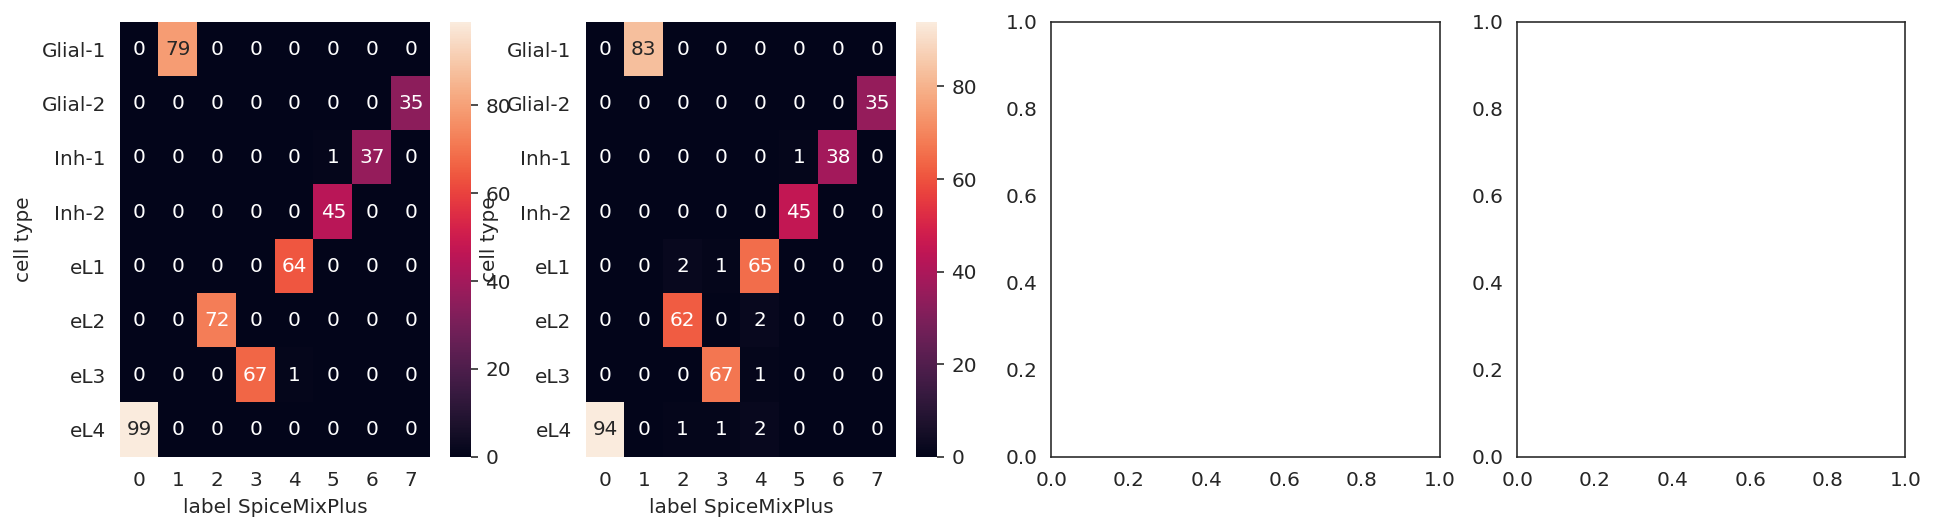

sil 0.7381518


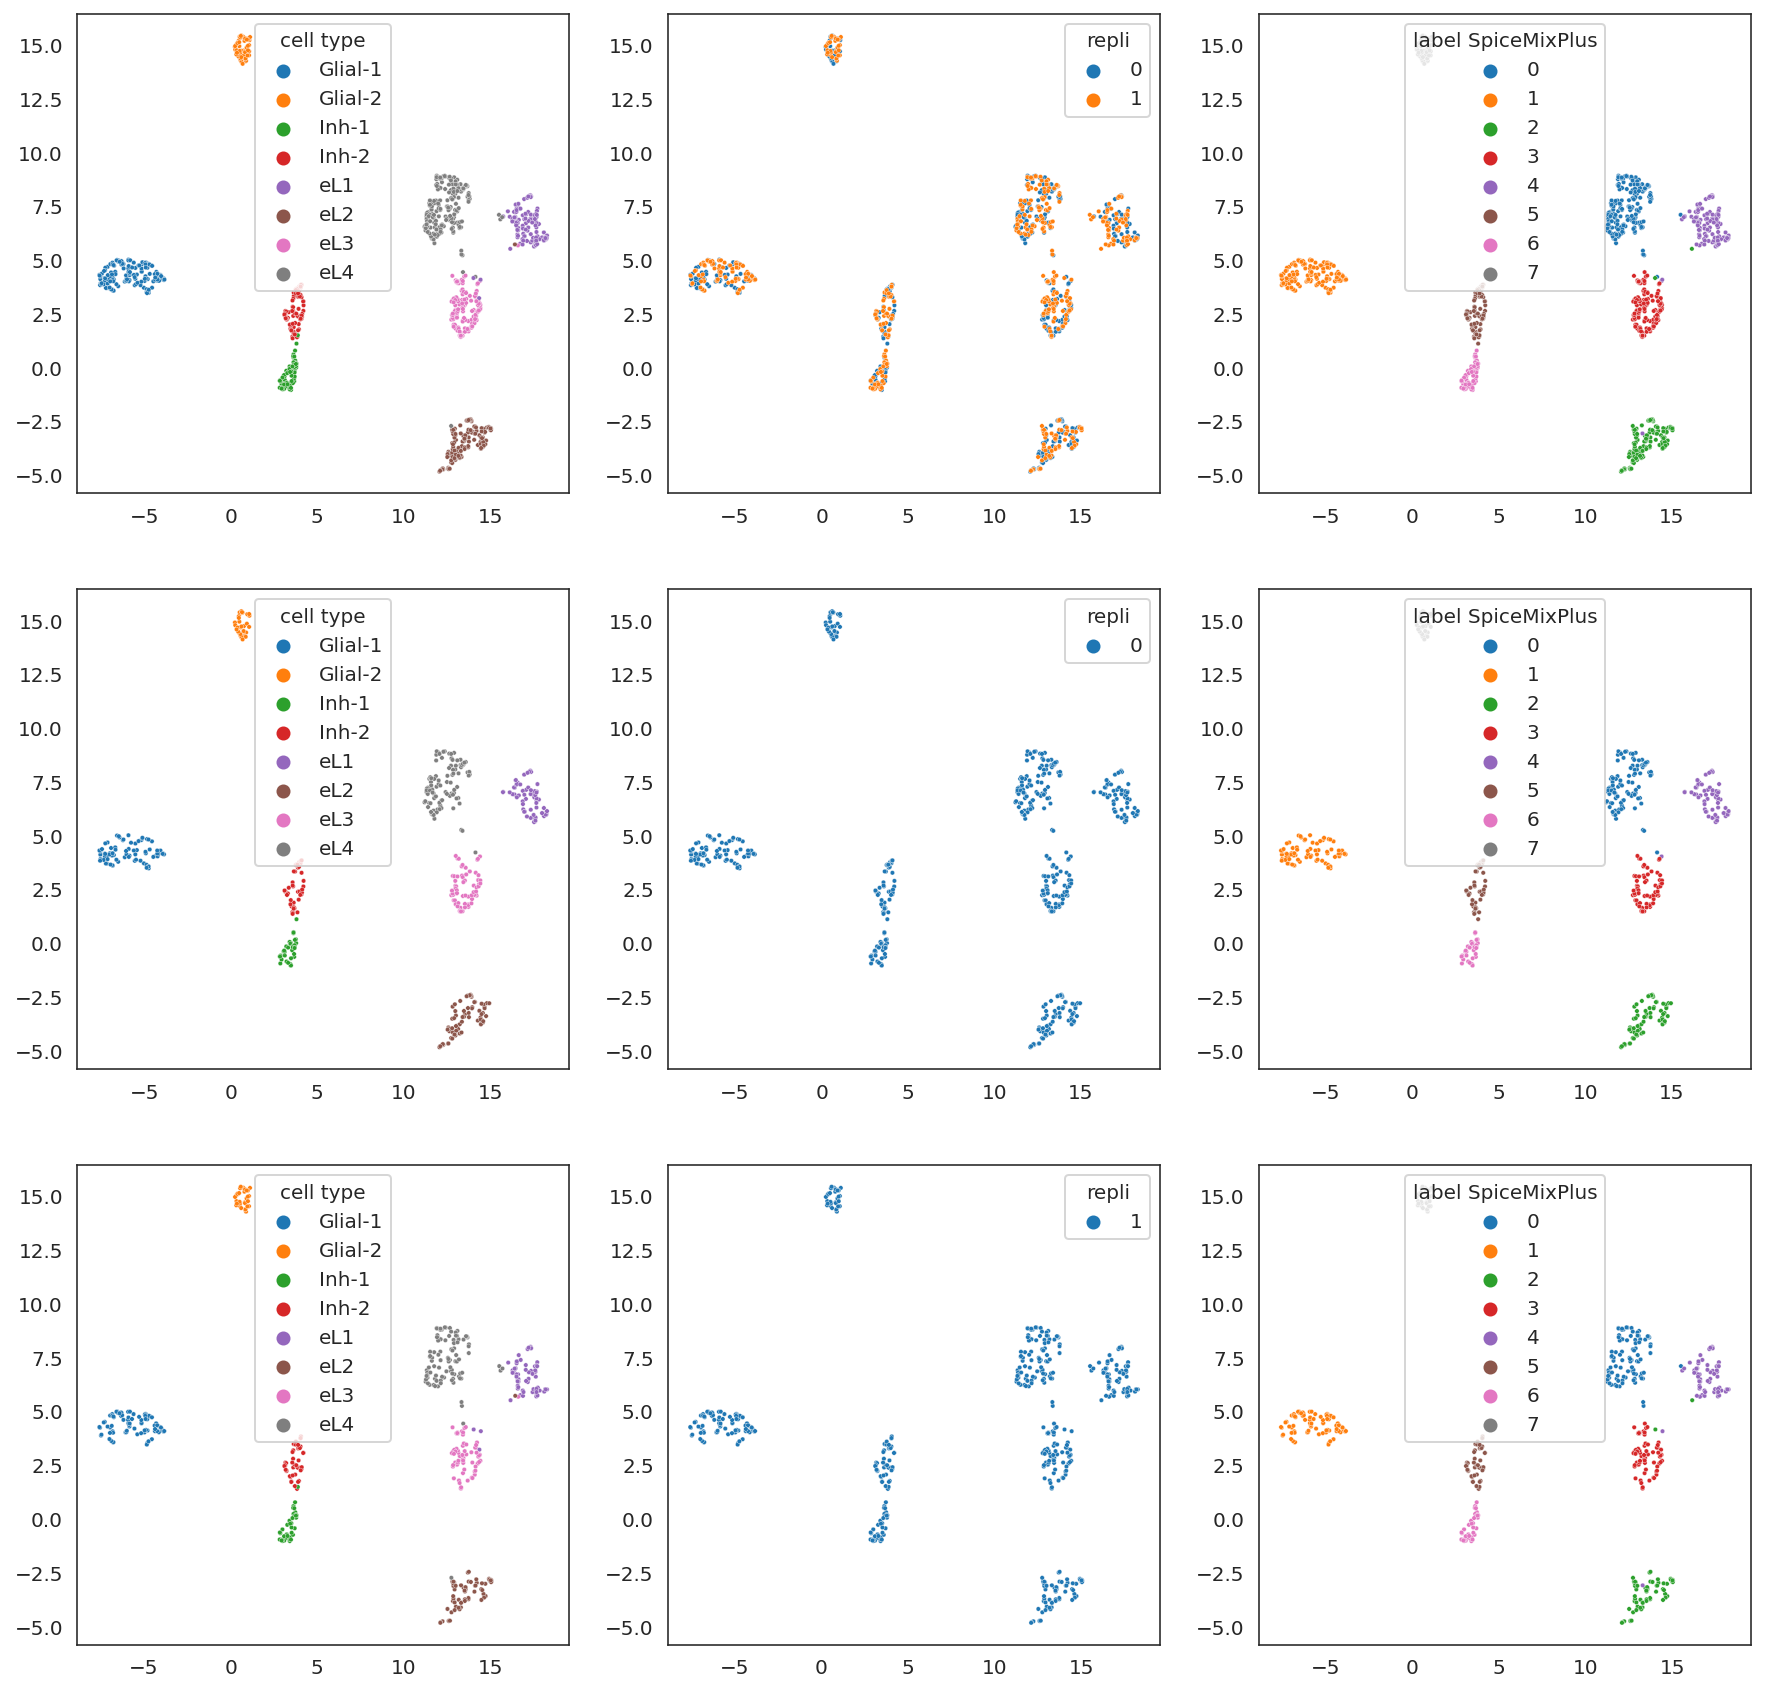

,acc,f1 micro,f1 macro,ari
0,0.99,0.99,0.990890,0.975994
1,0.98,0.98,0.979228,0.957457


Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/1000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/1000 [00:00<?, ?it/s]

hierarchical w/ K=6.ARI = 0.78
hierarchical w/ K=7.ARI = 0.90
hierarchical w/ K=8.ARI = 0.95
hierarchical w/ K=9.ARI = 0.87


Louvain clustering: res=3.16e-01:   0%|          | 0/100 [00:00<?, ?it/s]

ari = 0.97
ari 0 = 0.97
ari 1 = 0.96


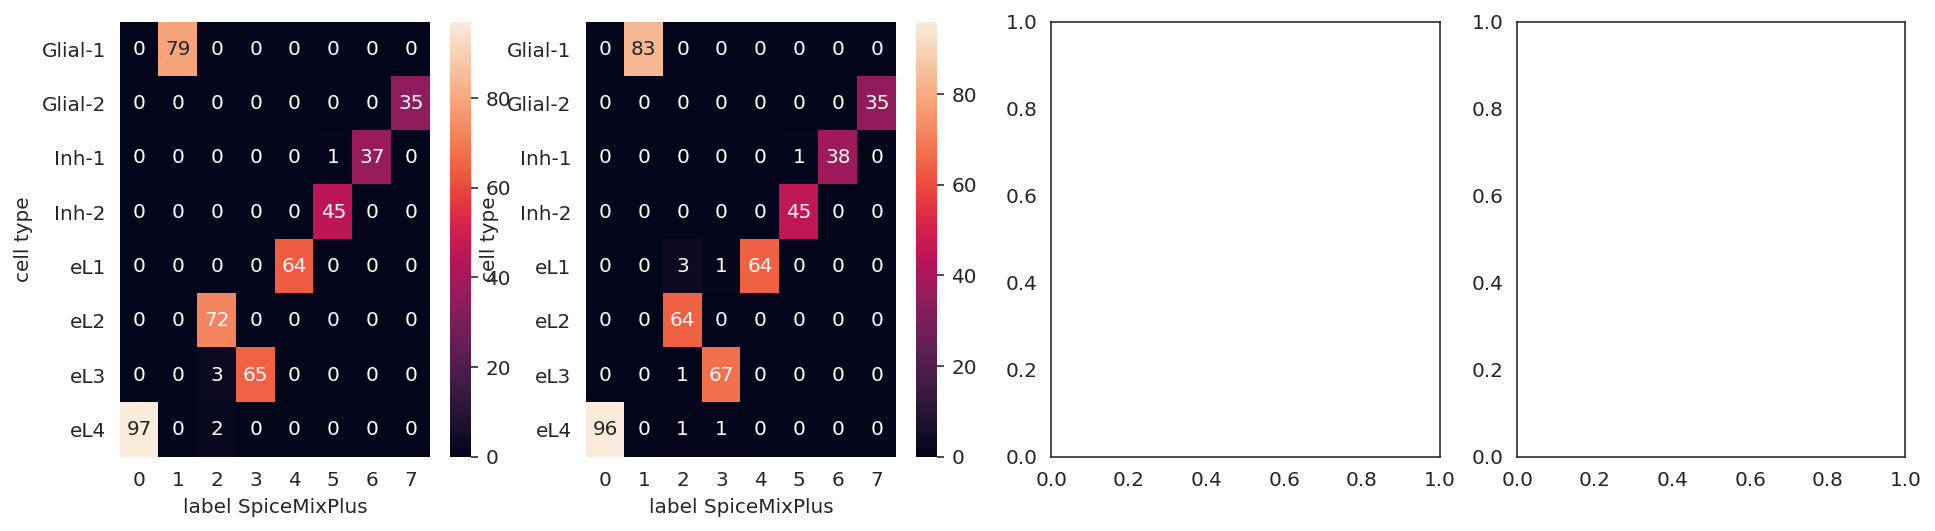

sil 0.7501676


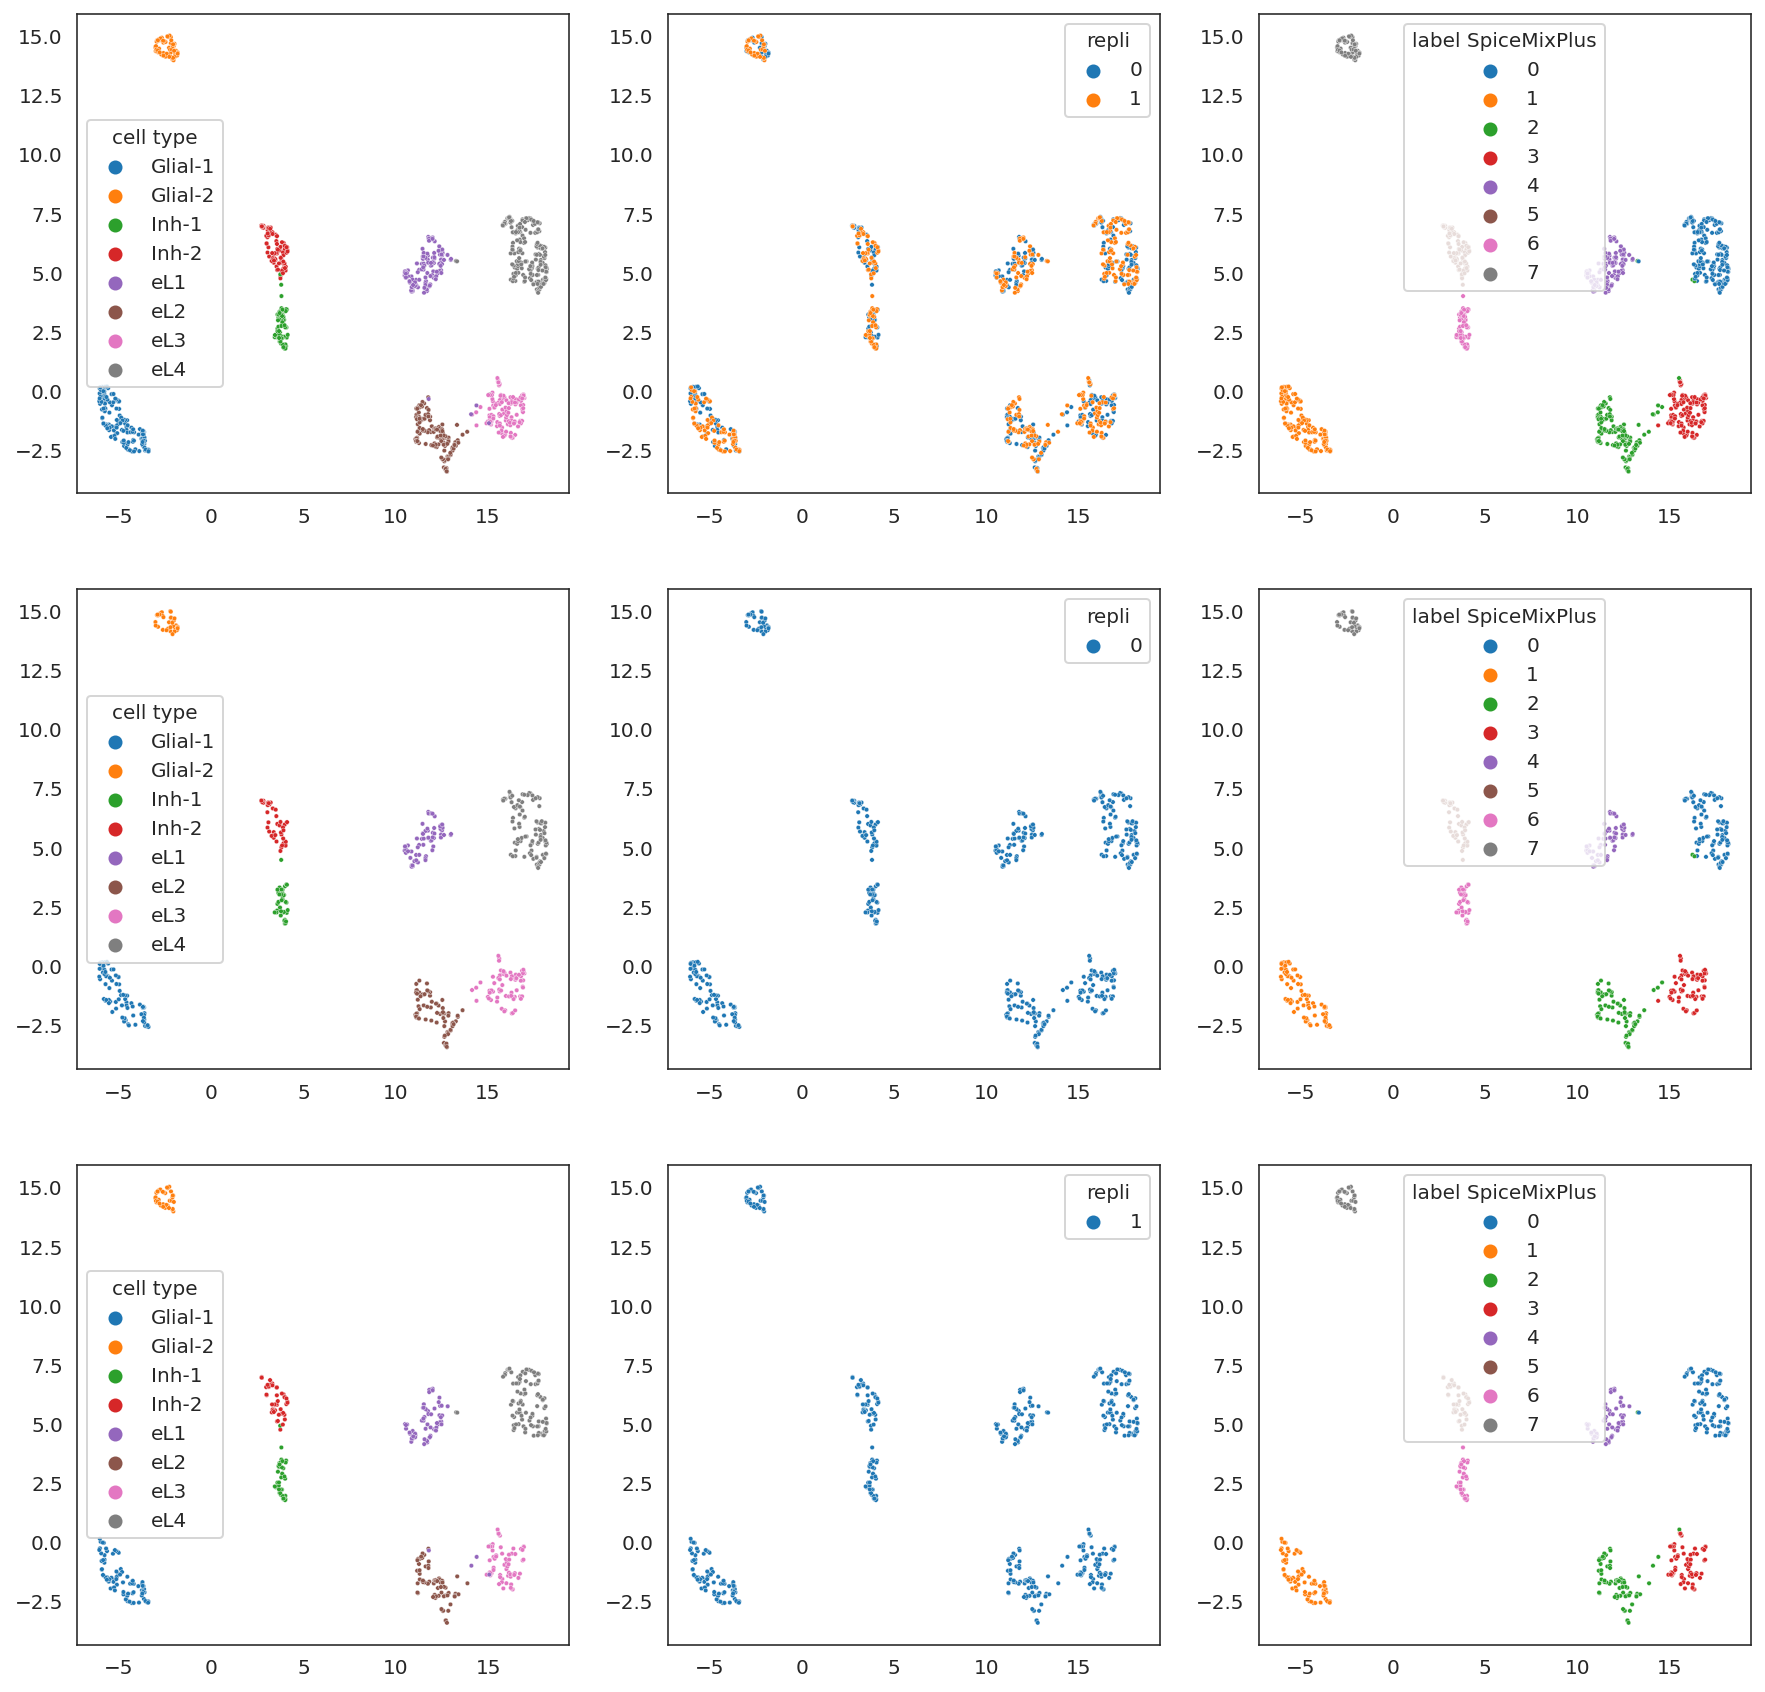

,acc,f1 micro,f1 macro,ari
0,0.988,0.988,0.988728,0.971450
1,0.980,0.980,0.978675,0.957191


CPU times: user 3min 44s, sys: 8.32 s, total: 3min 52s
Wall time: 3min 44s


In [5]:
%%time
reload_all()
from model import SpiceMixPlus
from util import clustering_louvain_nclust, evaluate_embedding, evaluate_prediction_wrapper
from sklearn.cluster import AgglomerativeClustering


# evaluate = lambda obj, f=evaluate_embedding: f(obj, embedding='X', do_plot=True, do_sil=True)
def evaluate(obj):
    evaluate_embedding(obj, embedding='X', do_plot=True, do_sil=True)
    evaluate_prediction_wrapper(obj, display_fn=display)

K = 10

obj = SpiceMixPlus(
    K=K, lambda_Sigma_x_inv=1e-2,
    repli_list=repli_list,
    context=context,
#     context_Y=dict(dtype=torch.float32, device='cpu'),
    context_Y=context,
)
obj.load_dataset(path2dataset)
obj.meta['cell type'] = obj.meta['cell type'].astype('category')

phenotype2predictor = {}
df = obj.meta
# cell type
label_raw = df['cell type']
label_a2i = dict(zip(np.unique(label_raw), itertools.count()))
label = list(map(label_a2i.get, label_raw))
df['cell type encoded'] = np.array(label, dtype=int)
predictor = nn.Linear(K, len(set(label)))
predictor = predictor.to(context['device'])
predictor.weight.data.normal_()
predictor.bias.data.normal_()
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-2, weight_decay=1e-2)
# loss_fn = nn.CrossEntropyLoss()
def loss_fn(yhat, y, state):
    if state == 'train':
         return torch.nn.functional.cross_entropy(yhat, y, reduction='mean')
    elif state == 'eval':
         return torch.nn.functional.cross_entropy(yhat, y, reduction='sum') * 1e1
    else:
        raise NotImplementError
phenotype2predictor['cell type encoded'] = (predictor, optimizer, loss_fn)
del label_raw, label, predictor, optimizer, loss_fn
obj.register_phenotype(phenotype2predictor)
print(obj.Ys)
obj.phenotypes[1]['cell type encoded'] = None

obj.initialize(
#     method='kmeans',
    method='svd',
#     random_state=4,
)
# evaluate(obj)
for iiter in trange(20):
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
evaluate(obj)
obj.initialize_Sigma_x_inv()

# obj.phenotypes = [{}]
# obj.phenotype_predictors = None

# obj.register_phenotype(phenotype2predictor)

for iiter in range(1, 11):
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    if iiter % 10 == 0:
        evaluate(obj)

In [11]:
#evaluate(obj)
Xs = [X.cpu().numpy() for X in obj.Xs]
x = np.concatenate(Xs, axis=0)
x = StandardScaler().fit_transform(x)
x = UMAP(
    random_state=obj.random_state,
    n_neighbors=10,
).fit_transform(x)
print(silhouette_score(x, obj.meta['cell type'], random_state=obj.random_state))

0.7501676


In [21]:
%debug

> /home/tianming/Researches/RNAseq-seqFISH/version1/scripts10/util.py(185)evaluate_prediction_wrapper()
    183         obj.meta['label SpiceMixPlus predictor'] = obj.phenotype_predictors[key_truth][0](X_all)\
    184                 .argmax(1).cpu().numpy()
--> 185         display_fn(evaluate_prediction(obj.meta, key_pred='label SpiceMixPlus predictor', key_truth=key_truth, **kwargs))
    186 
    187 

ipdb> evaluate_prediction(obj.meta, key_pred='label SpiceMixPlus predictor', key_truth=key_truth, **kwargs)
     acc  f1 micro  f1 macro       ari
0  0.747     0.747  0.781471  0.470119
1  0.747     0.747  0.781471  0.470119
ipdb> display_fn
ipdb> quit


In [23]:
reload_all()
from util import evaluate_prediction

X_train = obj.Xs[0].cpu().numpy()
X_all = np.concatenate([X.cpu().numpy() for X in obj.Xs], axis=0)
y_train = obj.meta.groupby('repli').get_group('0')['cell type'].values

# from sklearn.linear_model import LogisticRegression
# for C in 10.**np.arange(-5, 0):
#     print(C)
#     clf = LogisticRegression(C=C)
#     obj.meta['label baseline'] = clf.fit(X_train, y_train).predict(X_all)
#     display(evaluate_prediction(obj.meta, key_pred='label baseline'))

from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in np.arange(5, 31, 5):
    print(n_neighbors)
    clf = KNeighborsClassifier(n_neighbors)
    obj.meta['label baseline'] = clf.fit(X_train, y_train).predict(X_all)
    display(evaluate_prediction(obj.meta, key_pred='label baseline'))

5


,acc,f1 micro,f1 macro,ari
0,0.998,0.998,0.998396,0.994498
1,0.980,0.980,0.981143,0.953932


10


,acc,f1 micro,f1 macro,ari
0,0.996,0.996,0.995356,0.991715
1,0.978,0.978,0.979873,0.947529


15


,acc,f1 micro,f1 macro,ari
0,0.996,0.996,0.995356,0.991715
1,0.982,0.982,0.981821,0.960054


20


,acc,f1 micro,f1 macro,ari
0,0.996,0.996,0.995356,0.991715
1,0.988,0.988,0.988051,0.974410


25


,acc,f1 micro,f1 macro,ari
0,0.996,0.996,0.996608,0.989778
1,0.984,0.984,0.984966,0.963291


30


,acc,f1 micro,f1 macro,ari
0,0.994,0.994,0.993476,0.987232
1,0.986,0.986,0.985695,0.970864


In [ ]:
reload_all()
from util import evaluate_prediction
X_all = torch.cat([X for X in obj.Xs], axis=0)
obj.meta['label SpiceMixPlus predictor'] = obj.phenotype_predictors['cell type encoded'][0](X_all).argmax(1).cpu().numpy().astype(str)
display(evaluate_prediction(obj.meta, key_pred='label SpiceMixPlus predictor'))

In [79]:
reload_all()
from estimate_weights import estimate_weight_wonbr, estimate_weight_wnbr
N, G, K = 100, 50, 5
M = torch.rand(G, K, **context)
X = torch.rand(N, K, **context)
Y = X @ M.T + torch.randn(N, G, **context)*1e-2
Y.clip_(min=0)

X1 = X.clone()
estimate_weight_wonbr(
    Y, M, X1, 1, 
    'exponential shared fixed', (torch.full([K], 1e-2, **context),), context=context)
X2 = X.clone()
estimate_weight_wnbr(
    Y, M, X2, 1, 
    None, [[i] for i in range(N)],
    'exponential shared fixed', (torch.full([K], 1e-2, **context),), context=context)
print(torch.linalg.norm(X1-X2))
print(torch.linalg.norm(Y - X @ M.T))
print(torch.linalg.norm(Y - X1 @ M.T))
print(torch.linalg.norm(Y - X2 @ M.T))

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.0083, device='cuda:0')
tensor(0.7111, device='cuda:0')
tensor(0.6753, device='cuda:0')
tensor(0.6754, device='cuda:0')
